# Reconstruction notebook

This notebook contains all the code needed to evaluate the quality of MORPHEUS reconstructions and compare them with different baselines.

In [213]:
# make imports
from collections import OrderedDict

from morpheus.morpheus import MorpheusProto
from morpheus.utils.data import get_omics, prepare_omics_mapping
from morpheus.decoders import MorpheusDecoder
from morpheus.tokenizers import OmicsTokenizer, WSITokenizer
from morpheus.datasets import WSIMultiOmicsDataset
from morpheus.reverse_tokenizers import OmicsReverseTokenizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
from torch.utils.data import DataLoader
import torch

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "legend.fontsize": 9,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.figsize": (7, 5),
})

In [214]:
from itertools import combinations

def get_modality_combinations(modalities, target_modality):
    remaining = [m for m in modalities if m != target_modality]
    combos = []
    for r in range(1, len(remaining) + 1):
        for combo in combinations(remaining, r):
            combo_str = '-'.join(combo)
            combos.append(combo_str)
    return combos

In [215]:
omics_modalities = ['rna', 'dnam', 'cnv']
data_dir = 'path/to/data'
rna_pathways = 'hallmarks'
project_id = 'gbmlgg'
hidden_size = 256
decoder_num_heads = 8
num_layers_decoders = 1
num_layers = 1
device = 'cuda'
modality_to_reconstruct = 'dnam'
metadata = pd.read_csv(f'datasets_csv/metadata/tcga_{project_id}.csv')
metadata = metadata.dropna(subset=omics_modalities)
metadata = metadata[metadata.split == 'fine-tune']
mapping_modalities = {'dnam': 'DNAm', 'rna': 'RNA', 'cnv': 'CNV'}

In [216]:
omics_combination = get_modality_combinations(omics_modalities, modality_to_reconstruct)

In [217]:
omics_combination

['rna', 'cnv', 'rna-cnv']

In [218]:
metadata.shape

(228, 36)

In [219]:
reconstructions_data = {}
reconstructions_data['wsi'] = []
reconstructions_data['target'] = []
omics_combination = get_modality_combinations(omics_modalities, modality_to_reconstruct)
for combi in omics_combination:
    reconstructions_data[combi] = []


omics_data = get_omics(metadata, project_id=project_id, modalities=omics_modalities)
mapping_dicts = prepare_omics_mapping(omics_modalities)

omics_tokenizers = OrderedDict((modality, OmicsTokenizer(mapping_dicts[modality], output_dim=hidden_size, hidden=[256])) for modality in omics_modalities)
reverse_tokenizers = OrderedDict((modality, OmicsReverseTokenizer(mapping_dicts[modality], input_dim=hidden_size, hidden=[256])) for modality in omics_modalities)
omics_decoders = OrderedDict((modality, MorpheusDecoder(reverse_tokenizers[modality], modality=modality, hidden_size=hidden_size, num_layers=num_layers_decoders, num_heads=decoder_num_heads)) for modality in omics_modalities)
num_proto = 32
wsi_tokenizer = WSITokenizer(embed_dim=hidden_size, num_proto=num_proto)
model = MorpheusProto(wsi_tokenizer, omics_tokenizers=omics_tokenizers, omics_decoders=omics_decoders, omics_modalities=omics_modalities, hidden_size=hidden_size, num_layers=num_layers)
  
pretrained_path = f"pretrained_models/morpheus.pth"
model.load_state_dict(torch.load(pretrained_path))
model.to(device)
model.eval()
   
val_dataset = WSIMultiOmicsDataset(metadata, rna_dataframe=omics_data['rna'], rna_dict=mapping_dicts['rna'], dnam_dataframe=omics_data['dnam'], dnam_dict=mapping_dicts['dnam'], cnv_dataframe=omics_data['cnv'], cnv_dict=mapping_dicts['cnv'], mode='val', data_dir=data_dir)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
 
with torch.no_grad():
    for i, inputs in enumerate(tqdm.tqdm(val_dataloader, desc='Iterations...')):
        wsi = inputs['wsi'].to(device)
        omics_data = {modality: inputs[modality] for modality in omics_modalities}
        for modality in omics_data.keys():
            omics_data[modality] = {k: v.to(device) for k, v in omics_data[modality].items()}
                
        outputs_wsi = model.forward_encoder(wsi, {})
        predictions_wsi = omics_decoders[modality_to_reconstruct].decode(outputs_wsi)
        reconstructions_data['wsi'].append(torch.cat(list(predictions_wsi.values()), dim=1))

        for combi in omics_combination:
            temp_omics = {key: omics_data[key] for key in combi.split('-')}
            temp_outputs = model.forward_encoder(wsi, temp_omics)
            temp_predictions = omics_decoders[modality_to_reconstruct].decode(temp_outputs)
            reconstructions_data[combi].append(torch.cat(list(temp_predictions.values()), dim=1))
            
        reconstructions_data['target'].append(torch.cat(list(inputs[modality_to_reconstruct].values()), dim=1))

        

features = np.concatenate(list(mapping_dicts[modality_to_reconstruct].values()))
reconstructions_data = {key: pd.DataFrame(torch.cat(value).cpu().numpy(), columns=features) for key, value in reconstructions_data.items()}
reconstructions_data = {key: value.groupby(value.columns, axis=1).mean() for key, value in reconstructions_data.items()}

Iterations...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:29<00:00,  7.68it/s]
/tmp/ipykernel_167164/2187327833.py:50: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  reconstructions_data = {key: value.groupby(value.columns, axis=1).mean() for key, value in reconstructions_data.items()}
/tmp/ipykernel_167164/2187327833.py:50: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  reconstructions_data = {key: value.groupby(value.columns, axis=1).mean() for key, value in reconstructions_data.items()}
/tmp/ipykernel_167164/2187327833.py:50: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  reconstructions_data = {key: value.groupby(value.columns, axis=1).mean() for key, value in reconstructions_data.it

In [220]:
mask = reconstructions_data['target'].std() > 0.15
for key, value in reconstructions_data.items():
    if key == 'target':
        continue
    else:
        print(key)
        print(reconstructions_data['target'].loc[:, mask].corrwith(value.loc[:, mask]).median())

wsi
0.4594966348621883
rna
0.6565826671299461
cnv
0.4655764436907192
rna-cnv
0.6548883351913329


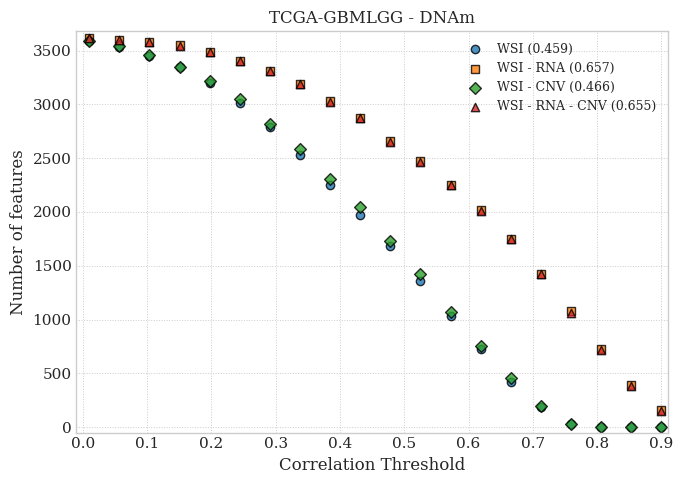

In [221]:
markers = ['o', 's', 'D', '^']
thresholds = np.linspace(0.01, 0.9, 20)
fig, ax = plt.subplots()
i = 0
for key in reconstructions_data.keys():
    if key == 'target':
        continue
    if key == 'wsi':
        label = 'WSI'
    else:
        list_label = key.split('-')
        list_label = [mapping_modalities[mod] for mod in list_label]
        label = 'WSI - ' + ' - '.join(list_label)
    n_features = []
    median = reconstructions_data['target'].loc[:, mask].corrwith(reconstructions_data[key].loc[:, mask]).median()
    label += f' ({median:.3f})' 
    for t in thresholds:
        n_features.append((reconstructions_data['target'].loc[:, mask].corrwith(reconstructions_data[key].loc[:, mask]) > t).sum())

    ax.scatter(thresholds, n_features, label=label, marker=markers[i], alpha=0.8, edgecolor='black')
    i += 1

# Axis labels and title
ax.set_xlabel("Correlation Threshold")
ax.set_ylabel("Number of features")
ax.set_title(f"TCGA-{project_id.upper()} - {mapping_modalities[modality_to_reconstruct]}")

# Axis limits and ticks
ax.set_xlim(-0.01, 0.91)
ax.set_ylim(-50, reconstructions_data['target'].loc[:, mask].shape[1] + 50)
#ax.set_yticks(np.linspace(0, 1, 6))
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Grid and legend
ax.grid(True, linestyle=':', linewidth=0.7)
ax.legend(loc='best')

# Layout and save
plt.tight_layout()
plt.savefig(f"figs/{project_id}/{modality_to_reconstruct}.pdf", dpi=300, bbox_inches='tight')
plt.show()

### Sanity Check

In [223]:
idh_wt = np.where(metadata.IDH == 'WT')[0]
idh_mut = np.where(metadata.IDH == 'Mutant')[0]

In [226]:
len(idh_wt)

66

In [227]:
from scipy.stats import ttest_ind

def compute_diff_methylation(df, group1, group2):
    pvals = []
    diffs = []
    for col in df.columns:
        g1 = df.iloc[group1][col]
        g2 = df.iloc[group2][col]
        stat, p = ttest_ind(g1, g2, equal_var=False)
        pvals.append(p)
        diffs.append(g1.mean() - g2.mean())
    return pd.DataFrame({'site': df.columns, 'delta_beta': diffs, 'pval': pvals})

In [228]:
real_results = compute_diff_methylation(reconstructions_data['target'], idh_mut, idh_wt)
wsi_results = compute_diff_methylation(reconstructions_data['wsi'], idh_mut, idh_wt)
wsi_rna_results = compute_diff_methylation(reconstructions_data['rna'], idh_mut, idh_wt)
wsi_cnv_results = compute_diff_methylation(reconstructions_data['cnv'], idh_mut, idh_wt)
wsi_rna_cnv_results = compute_diff_methylation(reconstructions_data['rna-cnv'], idh_mut, idh_wt)

In [229]:
real_results

,site,delta_beta,pval
0,cg00000292,0.269000,3.351102e-21
1,cg00002426,0.455891,4.943936e-30
2,cg00013618,0.058885,1.593551e-07
3,cg00015770,-0.021044,4.355997e-01
4,cg00016968,0.083759,6.548349e-12
...,...,...,...
7145,cg27637521,0.284051,7.960508e-15
7146,cg27648946,0.360160,5.212418e-35
7147,cg27650175,0.010036,1.658667e-05
7148,cg27652350,0.124363,1.906764e-04


In [230]:
hyper_real = set(real_results[(real_results['delta_beta'] > 0) & (real_results['pval'] < 0.1)]['site'])
hypo_real  = set(real_results[(real_results['delta_beta'] < 0) & (real_results['pval'] < 0.1)]['site'])

In [231]:
hyper_wsi = set(wsi_results[(wsi_results['delta_beta'] > 0) & (wsi_results['pval'] < 0.1)]['site'])
hypo_wsi  = set(wsi_results[(wsi_results['delta_beta'] < 0) & (wsi_results['pval'] < 0.1)]['site'])

hyper_wsi_rna = set(wsi_rna_results[(wsi_rna_results['delta_beta'] > 0) & (wsi_rna_results['pval'] < 0.1)]['site'])
hypo_wsi_rna  = set(wsi_rna_results[(wsi_rna_results['delta_beta'] < 0) & (wsi_rna_results['pval'] < 0.1)]['site'])

hyper_wsi_cnv = set(wsi_cnv_results[(wsi_cnv_results['delta_beta'] > 0) & (wsi_cnv_results['pval'] < 0.1)]['site'])
hypo_wsi_cnv = set(wsi_cnv_results[(wsi_cnv_results['delta_beta'] < 0) & (wsi_cnv_results['pval'] < 0.1)]['site'])

hyper_wsi_rna_cnv = set(wsi_rna_cnv_results[(wsi_rna_cnv_results['delta_beta'] > 0) & (wsi_rna_cnv_results['pval'] < 0.1)]['site'])
hypo_wsi_rna_cnv = set(wsi_rna_cnv_results[(wsi_rna_cnv_results['delta_beta'] < 0) & (wsi_rna_cnv_results['pval'] < 0.1)]['site'])

In [232]:
TP = len(hyper_real & hyper_wsi)
TN = len(hypo_real & hypo_wsi)
FP = len(hypo_real & hyper_wsi)
FN = len(hyper_real & hypo_wsi)

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9733


In [233]:
TP = len(hyper_real & hyper_wsi_rna)
TN = len(hypo_real & hypo_wsi_rna)
FP = len(hypo_real & hyper_wsi_rna)
FN = len(hyper_real & hypo_wsi_rna)

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9820


In [234]:
TP = len(hyper_real & hyper_wsi_cnv)
TN = len(hypo_real & hypo_wsi_cnv)
FP = len(hypo_real & hyper_wsi_cnv)
FN = len(hyper_real & hypo_wsi_cnv)

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9774


In [235]:
TP = len(hyper_real & hyper_wsi_rna_cnv)
TN = len(hypo_real & hypo_wsi_rna_cnv)
FP = len(hypo_real & hyper_wsi_rna_cnv)
FN = len(hyper_real & hypo_wsi_rna_cnv)

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9808
